# Siamese CNN & OCSVM

*Created by Holger Buech, Q1/2019*

**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [1]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

Using TensorFlow backend.


### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [2]:
# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [3]:
# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [66]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [67]:
P = VALID_FCN_ROBUST

**Overview of current Experiment Parameters:**

In [68]:
utils_ppp(P)

Value
batch_size                                                               300
epochs_best                                                               40
epochs_max                                                                80
exclude_subjects           [733162, 526319, 796581, 539502, 219303, 73797...
feature_cols                                           [acc_x, acc_y, acc_z]
filters                                                         [32, 64, 32]
frequency                                                                 25
margin                                                                     1
max_pairs_per_session                                                    600
max_subjects                                                              90
model_variant                                                            fcn
n_test_test_subjects                                                      30
n_test_train_subjects                                                     10
n_valid_test_subjects                                                     10
n_valid_train_subjects                                                    40
name                                                  VALID-FCN-ROBUST-FINAL
ocsvm_gamma                                                            8.296
ocsvm_nu                                                               0.165
optimizer                                                               adam
optimizer_decay                                                         None
optimizer_lr                                                           0.001
scaler                                                                robust
scaler_global                                                          False
scaler_scope                                                         subject
seconds_per_subject_test                                                 600
seconds_per_subject_train                                                600
step_width                                                               125
task_types                                                         [2, 4, 6]
window_size                                                              125

## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [7]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()

DataFrame  Memory (MB)      Rows  Columns  Subjects  Sessions
0       all      1437.64  14494937       12        90      1080
1     index         0.08      2160        4        90      2160

### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [8]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [9]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

DataFrame  Memory (MB)     Rows  Columns  Subjects  Sessions
0        index         0.08     2160        4        90      2160
1  valid_train       656.86  6622762       12        40       480
2   valid_test       169.38  1707776       12        10       120
3   test_train       145.71  1469069       12        10       120
4    test_test       465.69  4695330       12        30       360

### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

Scaling Data for Siamese Network only...
Training Data:
Before Scaling:


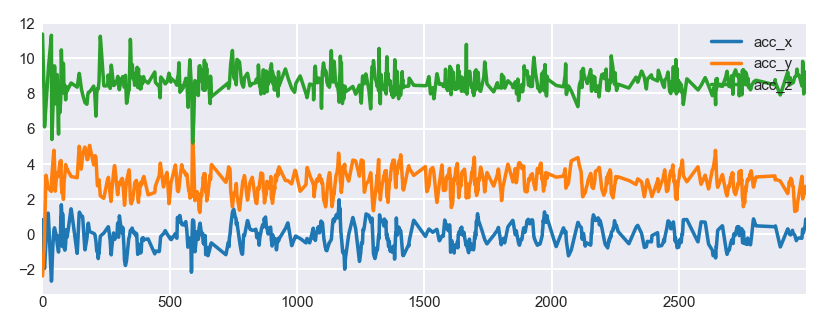

After Scaling:


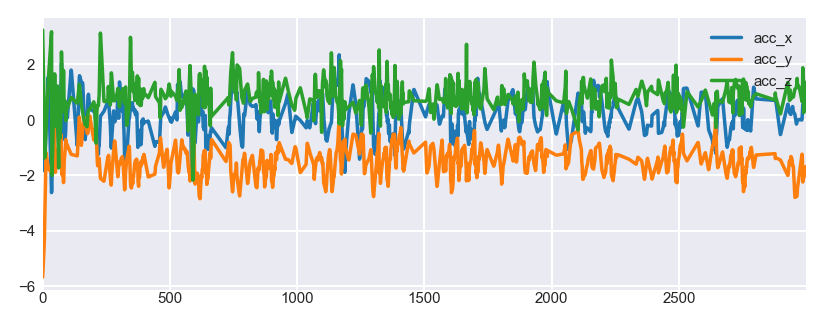

Validation Data:
Before Scaling:


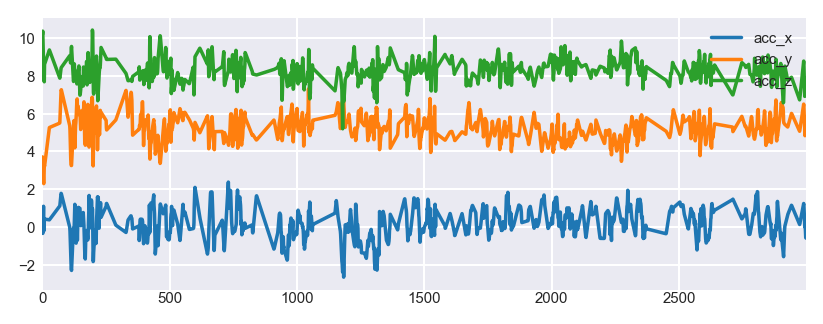

After Scaling:


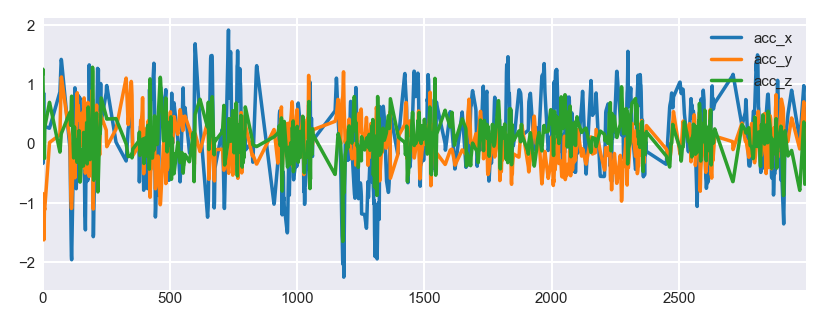

In [10]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

In [11]:
utils_split_report(hmog.valid_train)

Unique subjects: 40
Unique sessions: 480

Head:


acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z     mag_x      mag_y  mag_z subject            session  task_type
0  1.126539 -5.676733  3.232535  0.544714 -0.159665  0.029449  6.826999  32.188268   8.67  100669  100669_session_12          6
1  0.726045 -5.490228  2.748784  0.621841 -0.121316  0.017797  7.146999  31.996983   8.67  100669  100669_session_12          6
2  0.325552 -5.303724  2.265033  0.698968 -0.082967  0.006145  7.466999  31.805697   8.67  100669  100669_session_12          6
3 -0.074942 -5.117219  1.781282  0.776096 -0.044619 -0.005506  7.786999  31.614411   8.67  100669  100669_session_12          6
4 -0.475436 -4.930714  1.297531  0.853223 -0.006270 -0.017158  8.106999  31.423126   8.67  100669  100669_session_12          6



Sessions' Task Types per subject:


subject  100669  171538  201848  220962  261313  277905  278135  326223  342329  366286  368258  395129  398248  472761  489146  525584  527796  538363  540641  556357  588087  657486  693572  698266  710707  745224  763813  827212  863985  865501  872895  876011  879155  892687  893255  897652  918136  966655  973891  990622
2             4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4
4             4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4
6             4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4

In [12]:
utils_split_report(hmog.valid_test)

Unique subjects: 10
Unique sessions: 120

Head:


acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z     mag_x     mag_y      mag_z subject           session  task_type
0 -0.042820 -0.841897  1.159331  0.418076 -0.425025  0.154106  7.509463  5.205567 -35.976860  257279  257279_session_1          6
1 -0.335043 -1.059704  1.256299  0.524367 -0.296209  0.229930  7.434780  4.952402 -35.692659  257279  257279_session_1          6
2  0.061697 -1.233816  0.944090  0.430375 -0.343123  0.151413  7.514585  4.670094 -35.519911  257279  257279_session_1          6
3  0.458436 -1.407928  0.631880  0.336383 -0.390037  0.072897  7.594390  4.387785 -35.347163  257279  257279_session_1          6
4  0.855176 -1.582041  0.319670  0.202306 -0.300045 -0.043262  7.674195  4.105476 -35.174415  257279  257279_session_1          6



Sessions' Task Types per subject:


subject  257279  396697  554303  594887  621276  733568  777078  815316  923862  984799
2             4       4       4       4       4       4       4       4       4       4
4             4       4       4       4       4       4       4       4       4       4
6             4       4       4       4       4       4       4       4       4       4

In [13]:
utils_split_report(hmog.test_train)

Unique subjects: 10
Unique sessions: 120

Head:


acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z     mag_x      mag_y      mag_z subject            session  task_type
0  1.397885  6.634745  8.873776  0.097367 -0.261735  0.130239  2.587439 -11.002091 -11.930931  207696  207696_session_11          2
1  1.256549  6.640633  8.687734  0.146060 -0.184967 -0.084313  2.503170 -11.222939 -11.932120  207696  207696_session_11          2
2  1.115212  6.646520  8.501693  0.001951 -0.150648 -0.155729  2.424210 -11.444220 -11.929560  207696  207696_session_11          2
3  0.973876  6.652407  8.315652 -0.142158 -0.116328 -0.227145  2.345250 -11.665500 -11.927000  207696  207696_session_11          2
4  0.832540  6.658295  8.129611 -0.286267 -0.082009 -0.298561  2.266290 -11.886780 -11.924440  207696  207696_session_11          2



Sessions' Task Types per subject:


subject  207696  240168  352716  431312  578526  622852  776328  785899  856302  980953
2             4       4       4       4       4       4       4       4       4       4
4             4       4       4       4       4       4       4       4       4       4
6             4       4       4       4       4       4       4       4       4       4

In [14]:
utils_split_report(hmog.test_test)

Unique subjects: 30
Unique sessions: 360

Head:


acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z      mag_x      mag_y      mag_z subject            session  task_type
0 -0.376539  3.110742  7.732258 -0.042379 -0.081758 -0.053667 -29.872625  11.404750 -37.032375  151985  151985_session_10          6
1 -0.376673  3.125309  7.726362 -0.047065 -0.074980 -0.064833 -29.868323  11.511205 -37.468728  151985  151985_session_10          6
2 -0.376807  3.139875  7.720466 -0.051750 -0.068202 -0.075998 -29.872394  11.623124 -37.545312  151985  151985_session_10          6
3 -0.376941  3.154442  7.714570 -0.056435 -0.061424 -0.087164 -29.878560  11.736408 -37.531954  151985  151985_session_10          6
4 -0.377076  3.169009  7.708674 -0.061120 -0.054646 -0.098329 -29.884725  11.849693 -37.518596  151985  151985_session_10          6



Sessions' Task Types per subject:


subject  151985  180679  186676  218719  248252  264325  336172  405035  501973  553321  561993  579284  663153  675397  717868  720193  751131  771782  785873  799296  803262  808022  841866  862649  865881  893198  913228  937904  962159  998757
2             4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4
4             4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4
6             4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4       4

### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

In [15]:
df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
df_siamese_train.to_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


X subject            session  task_type
0  [[1.126538556309365, -5.676733181236054, 3.232...  100669  100669_session_12          6
1  [[0.35454249979518676, -1.2795481927044285, 0....  100669  100669_session_12          6
2  [[0.5150551243002253, -1.6982955451723616, 0.6...  100669  100669_session_12          6
3  [[-0.9393853286507788, -2.2431333573807604, 1....  100669  100669_session_12          6
4  [[0.00042849556207466284, -2.142130982688511, ...  100669  100669_session_12          6

**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

In [16]:
df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
df_siamese_valid.to_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


X subject           session  task_type
0  [[-0.04281976952530689, -0.8418968191771367, 1...  257279  257279_session_1          6
1  [[0.13079446862052027, 0.10234259964161609, 0....  257279  257279_session_1          6
2  [[0.8587300291499387, 0.22569888511439404, 0.4...  257279  257279_session_1          6
3  [[-0.027996045361265667, -0.05663118972213963,...  257279  257279_session_1          6
4  [[-0.25892495983972386, 0.3904236255845561, 0....  257279  257279_session_1          6

**Reshape & cache Set for Training/Validation OCSVM:**

In [17]:
df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


X subject            session  task_type
0  [[1.3978850635805664, 6.634745158553127, 8.873...  207696  207696_session_11          2
1  [[0.8989105212499999, 7.4393458625, 5.20084218...  207696  207696_session_11          2
2  [[-0.8528512094444445, 5.462304877777777, 7.74...  207696  207696_session_11          2
3  [[-2.062305483175016, 4.1703999289186555, 7.23...  207696  207696_session_11          2
4  [[-0.9964742910047201, 4.9818725305168, 8.2125...  207696  207696_session_11          2

**Reshape & cache Set for Training/Testing OCSVM:**

In [18]:
df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


X subject            session  task_type
0  [[-0.3765385456074766, 3.1107421714953274, 7.7...  151985  151985_session_10          6
1  [[0.09549826478869189, 3.9700954602219136, 7.7...  151985  151985_session_10          6
2  [[0.20883461625482397, 3.2271731154792, 8.6506...  151985  151985_session_10          6
3  [[0.0038022012564349096, 3.0280049158538764, 9...  151985  151985_session_10          6
4  [[-2.4728418720348535, 3.5376784001577266, 7.4...  151985  151985_session_10          6

## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [19]:
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

In [20]:
def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), P.max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [21]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


527796_session_2    387
876011_session_4    339
278135_session_2    312
Name: session, dtype: int64

733568_session_2    417
396697_session_1    330
621276_session_1    286
Name: session, dtype: int64



Sample per session after reduction:



527796_session_23    120
201848_session_18    120
763813_session_21    120
Name: session, dtype: int64

923862_session_3     120
396697_session_20    120
396697_session_2     120
Name: session, dtype: int64

In [22]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23588 entries, 0 to 23587
Data columns (total 9 columns):
left_X             23588 non-null object
left_subject       23588 non-null object
left_session       23588 non-null object
left_task_type     23588 non-null int64
right_X            23588 non-null object
right_subject      23588 non-null object
right_session      23588 non-null object
right_task_type    23588 non-null int64
label              23588 non-null int32
dtypes: int32(1), int64(2), object(6)
memory usage: 1.5+ MB


None



Head:


left_X left_subject       left_session  left_task_type                                            right_X right_subject      right_session  right_task_type  label
0  ((-0.6109400484616416, -0.2985873893344089, 0....       897652   897652_session_1               4  ((0.012159576998761815, -0.36924814907480535, ...        897652   897652_session_3                4      1
1  ((-0.6852879208892871, -0.9106812206065279, 0....       872895  872895_session_22               6  ((0.2728577258370753, 0.1530996859164123, 0.12...        366286   366286_session_8                4      0
2  ((0.7498410738002906, -0.8684983280458387, 0.5...       698266  698266_session_19               4  ((-0.46279022447070506, -0.555800585238564, 0....        220962   220962_session_8                4      0
3  ((0.10867531040347118, 0.23984956160676224, -0...       865501  865501_session_17               6  ((0.21876142696935683, -0.45017171880626056, 0...        865501   865501_session_4                4      1
4  ((-0.22910759516846307, 0.011331173792316513, ...       990622  990622_session_12               4  ((1.9707319594446044, 0.7584409371607767, -0.8...        990622  990622_session_24                4      1



Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


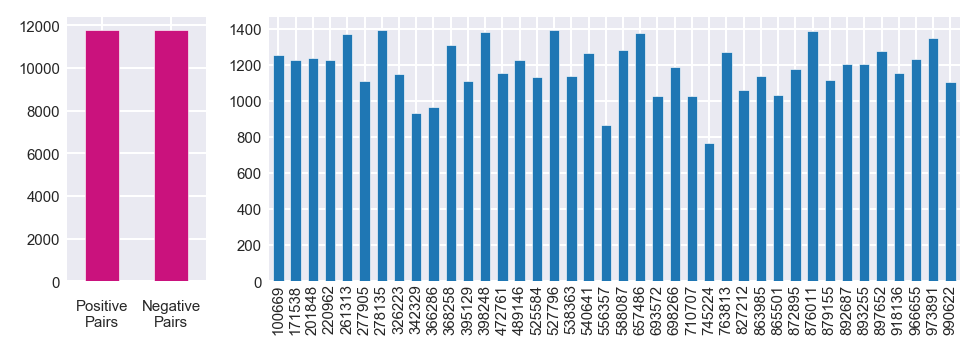

In [23]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pair-dist.pdf")

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

In [24]:
df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

In [25]:
# Clean Memory
%reset_selective -f df_

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [26]:
df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

In [27]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [28]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

Sanity check contrastive loss function:

In [29]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [30]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1


In [31]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=5,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 1
Negative: class=0, distance=0.01,  loss: 0.9801
Negative: class=0, distance=0.3,   loss: 0.48999999999999994
Negative: class=0, distance=0.5,   loss: 0.25
Negative: class=0, distance=5,     loss: 0


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [32]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [33]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [34]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [35]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

In [36]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant fcn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 125, 3)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 32)           800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 32)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 125, 32)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64)     

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [37]:
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [38]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   23588, shape: (23588, 125, 3), class balance: (array([0, 1]), array([11794, 11794], dtype=int64))
Validation samples: 5916, shape: (5916, 125, 3), class balance: (array([0, 1]), array([2958, 2958], dtype=int64))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [39]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [40]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

Using Model variant fcn...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.5053, eer: 0.4963, thres: 0.0708 => acc: 0.5038, f1: 0.5039



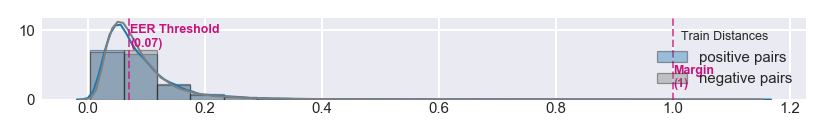


VALID: roc_auc: 0.4983, eer: 0.5020, thres: 0.0785 => acc: 0.4978, f1: 0.4979



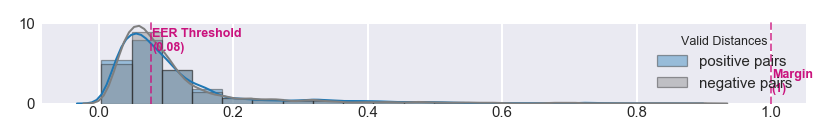

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.6233, eer: 0.4151, thres: 0.4493 => acc: 0.5848, f1: 0.5848
val_loss: 0.258, loss: 0.264


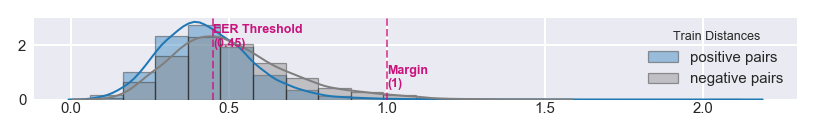


VALID: roc_auc: 0.5675, eer: 0.4577, thres: 0.4857 => acc: 0.5423, f1: 0.5421
val_loss: 0.258, loss: 0.264


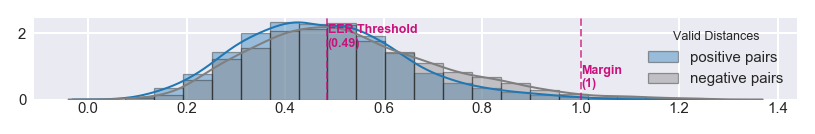

================================[   Epoch 1   ]================================
val_loss: 0.240, loss: 0.235
================================[   Epoch 2   ]================================
val_loss: 0.224, loss: 0.221
================================[   Epoch 3   ]================================
val_loss: 0.212, loss: 0.212
================================[   Epoch 4   ]================================
val_loss: 0.203, loss: 0.209
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.7453, eer: 0.3284, thres: 0.4499 => acc: 0.6715, f1: 0.6715
val_loss: 0.195, loss: 0.204


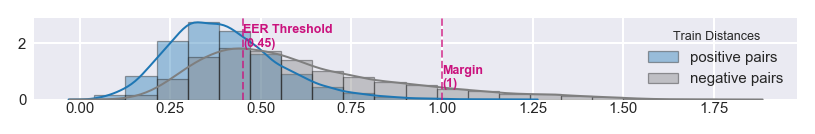


VALID: roc_auc: 0.7683, eer: 0.3010, thres: 0.5094 => acc: 0.6995, f1: 0.6994
val_loss: 0.195, loss: 0.204


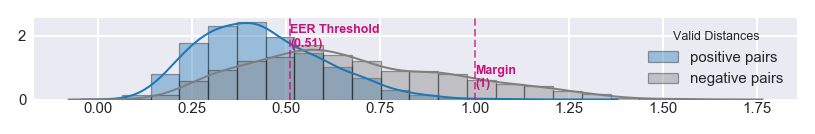

================================[   Epoch 6   ]================================
val_loss: 0.206, loss: 0.202
================================[   Epoch 7   ]================================
val_loss: 0.193, loss: 0.199
================================[   Epoch 8   ]================================
val_loss: 0.186, loss: 0.196
================================[   Epoch 9   ]================================
val_loss: 0.184, loss: 0.194
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.7890, eer: 0.2917, thres: 0.4903 => acc: 0.7083, f1: 0.7083
val_loss: 0.181, loss: 0.192


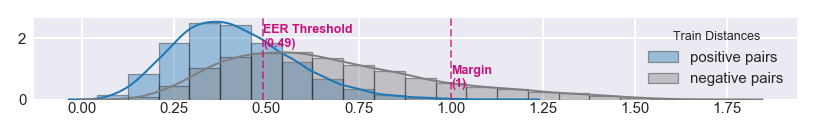


VALID: roc_auc: 0.8135, eer: 0.2640, thres: 0.5319 => acc: 0.7361, f1: 0.7361
val_loss: 0.181, loss: 0.192


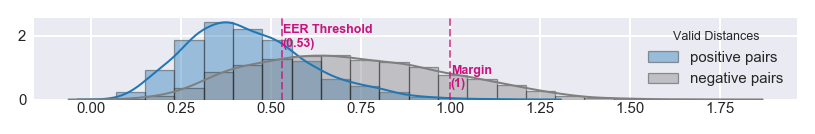

================================[   Epoch 11   ]================================
val_loss: 0.182, loss: 0.190
================================[   Epoch 12   ]================================
val_loss: 0.190, loss: 0.190
================================[   Epoch 13   ]================================
val_loss: 0.179, loss: 0.188
================================[   Epoch 14   ]================================
val_loss: 0.183, loss: 0.187
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.8075, eer: 0.2742, thres: 0.5046 => acc: 0.7258, f1: 0.7257
val_loss: 0.179, loss: 0.184


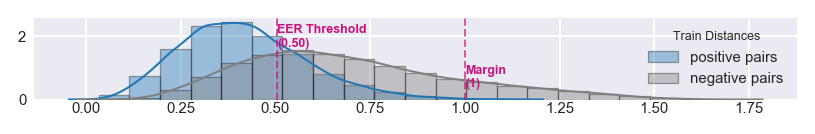


VALID: roc_auc: 0.8167, eer: 0.2708, thres: 0.5309 => acc: 0.7294, f1: 0.7293
val_loss: 0.179, loss: 0.184


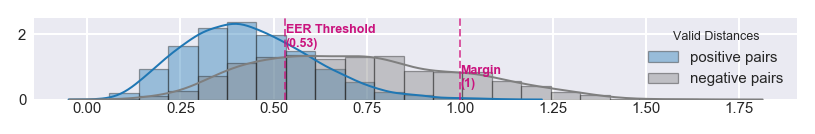

================================[   Epoch 16   ]================================
val_loss: 0.184, loss: 0.184
================================[   Epoch 17   ]================================
val_loss: 0.184, loss: 0.182
================================[   Epoch 18   ]================================
val_loss: 0.175, loss: 0.182
================================[   Epoch 19   ]================================
val_loss: 0.175, loss: 0.181
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.8199, eer: 0.2614, thres: 0.5061 => acc: 0.7386, f1: 0.7386
val_loss: 0.173, loss: 0.179


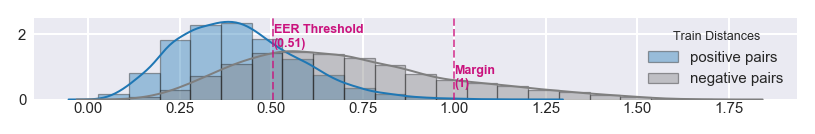


VALID: roc_auc: 0.8320, eer: 0.2552, thres: 0.5298 => acc: 0.7448, f1: 0.7447
val_loss: 0.173, loss: 0.179


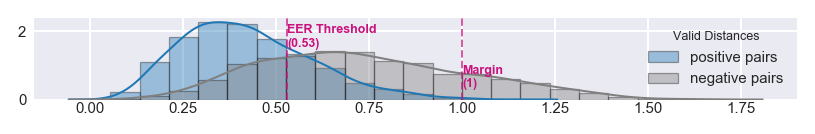

================================[   Epoch 21   ]================================
val_loss: 0.177, loss: 0.178
================================[   Epoch 22   ]================================
val_loss: 0.178, loss: 0.177
================================[   Epoch 23   ]================================
val_loss: 0.175, loss: 0.177
================================[   Epoch 24   ]================================
val_loss: 0.176, loss: 0.174
================================[   Epoch 25   ]================================
TRAIN: roc_auc: 0.8246, eer: 0.2604, thres: 0.5265 => acc: 0.7396, f1: 0.7396
val_loss: 0.180, loss: 0.174


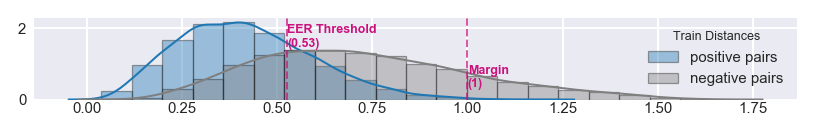


VALID: roc_auc: 0.8233, eer: 0.2583, thres: 0.5638 => acc: 0.7417, f1: 0.7416
val_loss: 0.180, loss: 0.174


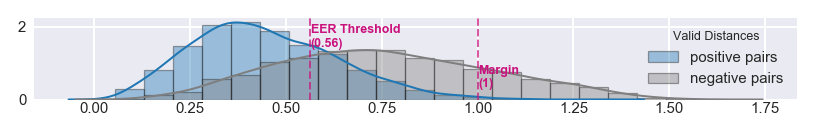

================================[   Epoch 26   ]================================
val_loss: 0.179, loss: 0.173
================================[   Epoch 27   ]================================
val_loss: 0.171, loss: 0.172
================================[   Epoch 28   ]================================
val_loss: 0.178, loss: 0.171
================================[   Epoch 29   ]================================
val_loss: 0.176, loss: 0.171
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.8432, eer: 0.2423, thres: 0.5127 => acc: 0.7576, f1: 0.7576
val_loss: 0.175, loss: 0.170


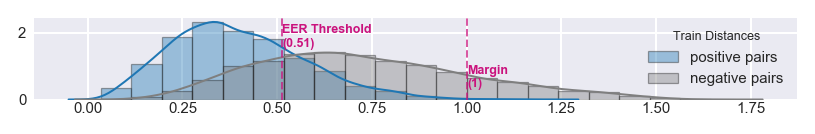


VALID: roc_auc: 0.8307, eer: 0.2512, thres: 0.5571 => acc: 0.7490, f1: 0.7489
val_loss: 0.175, loss: 0.170


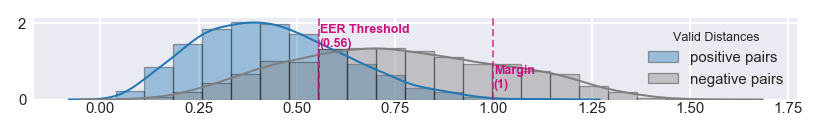

================================[   Epoch 31   ]================================
val_loss: 0.176, loss: 0.169
================================[   Epoch 32   ]================================
val_loss: 0.181, loss: 0.169
================================[   Epoch 33   ]================================
val_loss: 0.169, loss: 0.167
================================[   Epoch 34   ]================================
val_loss: 0.171, loss: 0.167
================================[   Epoch 35   ]================================
TRAIN: roc_auc: 0.8445, eer: 0.2419, thres: 0.5164 => acc: 0.7581, f1: 0.7581
val_loss: 0.179, loss: 0.165


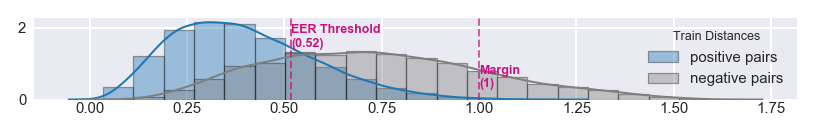


VALID: roc_auc: 0.8198, eer: 0.2634, thres: 0.5534 => acc: 0.7366, f1: 0.7366
val_loss: 0.179, loss: 0.165


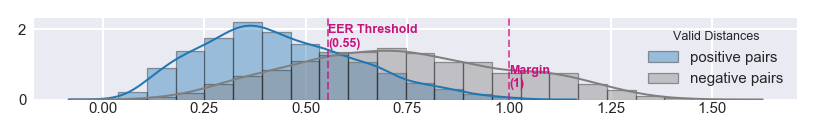

================================[   Epoch 36   ]================================
val_loss: 0.174, loss: 0.165
================================[   Epoch 37   ]================================
val_loss: 0.171, loss: 0.166
================================[   Epoch 38   ]================================
val_loss: 0.170, loss: 0.165
================================[   Epoch 39   ]================================
val_loss: 0.170, loss: 0.163
================================[   Epoch 40   ]================================
TRAIN: roc_auc: 0.8621, eer: 0.2282, thres: 0.5050 => acc: 0.7718, f1: 0.7718
val_loss: 0.169, loss: 0.162


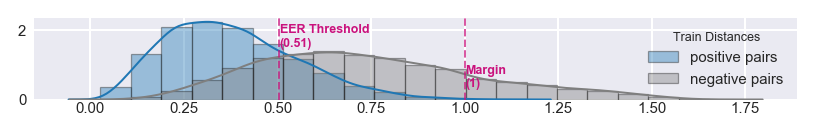


VALID: roc_auc: 0.8435, eer: 0.2387, thres: 0.5507 => acc: 0.7613, f1: 0.7613
val_loss: 0.169, loss: 0.162


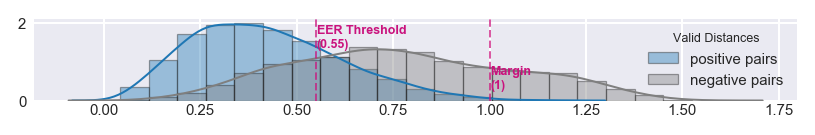

================================[   Epoch 41   ]================================
val_loss: 0.174, loss: 0.163
================================[   Epoch 42   ]================================
val_loss: 0.171, loss: 0.161
================================[   Epoch 43   ]================================
val_loss: 0.169, loss: 0.161
================================[   Epoch 44   ]================================
val_loss: 0.171, loss: 0.160
================================[   Epoch 45   ]================================
TRAIN: roc_auc: 0.8636, eer: 0.2256, thres: 0.4985 => acc: 0.7743, f1: 0.7743
val_loss: 0.173, loss: 0.160


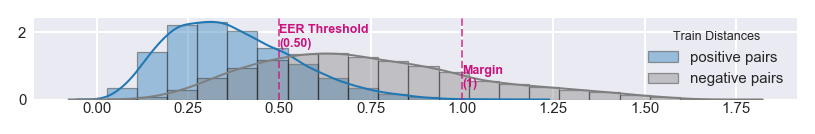


VALID: roc_auc: 0.8312, eer: 0.2481, thres: 0.5426 => acc: 0.7519, f1: 0.7518
val_loss: 0.173, loss: 0.160


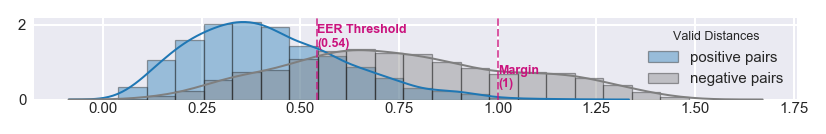

================================[   Epoch 46   ]================================
val_loss: 0.181, loss: 0.160
================================[   Epoch 47   ]================================
val_loss: 0.175, loss: 0.160
================================[   Epoch 48   ]================================
val_loss: 0.176, loss: 0.158
================================[   Epoch 49   ]================================
val_loss: 0.167, loss: 0.158
================================[   Epoch 50   ]================================
TRAIN: roc_auc: 0.8688, eer: 0.2217, thres: 0.5279 => acc: 0.7784, f1: 0.7784
val_loss: 0.175, loss: 0.160


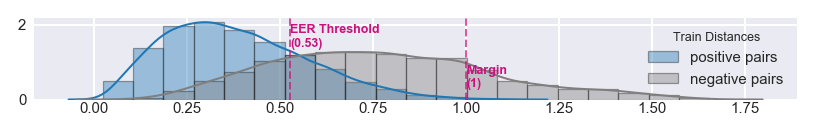


VALID: roc_auc: 0.8322, eer: 0.2529, thres: 0.5668 => acc: 0.7471, f1: 0.7470
val_loss: 0.175, loss: 0.160


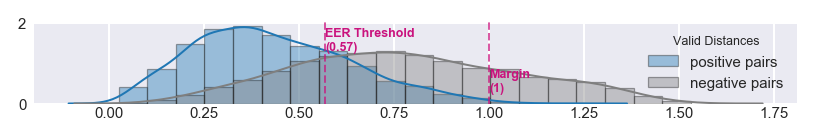

================================[   Epoch 51   ]================================
val_loss: 0.176, loss: 0.158
================================[   Epoch 52   ]================================
val_loss: 0.170, loss: 0.158
================================[   Epoch 53   ]================================
val_loss: 0.170, loss: 0.157
================================[   Epoch 54   ]================================
val_loss: 0.170, loss: 0.157
================================[   Epoch 55   ]================================
TRAIN: roc_auc: 0.8705, eer: 0.2177, thres: 0.5129 => acc: 0.7823, f1: 0.7823
val_loss: 0.175, loss: 0.156


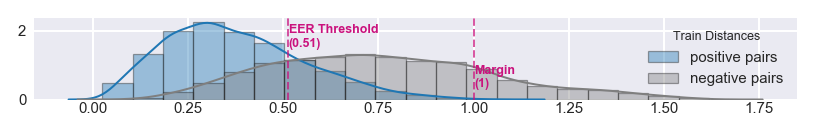


VALID: roc_auc: 0.8295, eer: 0.2567, thres: 0.5616 => acc: 0.7436, f1: 0.7436
val_loss: 0.175, loss: 0.156


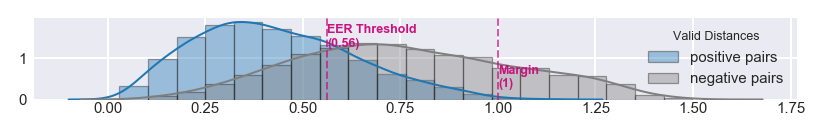

================================[   Epoch 56   ]================================
val_loss: 0.179, loss: 0.156
================================[   Epoch 57   ]================================
val_loss: 0.175, loss: 0.156
================================[   Epoch 58   ]================================
val_loss: 0.175, loss: 0.156
================================[   Epoch 59   ]================================
val_loss: 0.173, loss: 0.155
================================[   Epoch 60   ]================================
TRAIN: roc_auc: 0.8667, eer: 0.2209, thres: 0.5277 => acc: 0.7791, f1: 0.7791
val_loss: 0.180, loss: 0.155


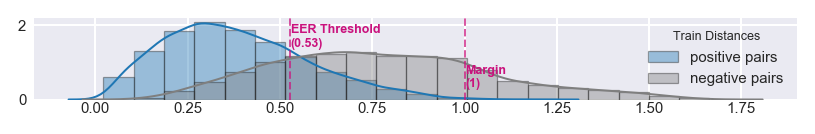


VALID: roc_auc: 0.8236, eer: 0.2650, thres: 0.5723 => acc: 0.7348, f1: 0.7347
val_loss: 0.180, loss: 0.155


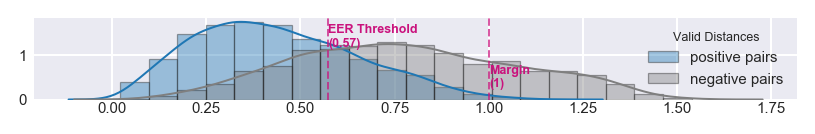

================================[   Epoch 61   ]================================
val_loss: 0.176, loss: 0.155
================================[   Epoch 62   ]================================
val_loss: 0.168, loss: 0.154
================================[   Epoch 63   ]================================
val_loss: 0.172, loss: 0.154
================================[   Epoch 64   ]================================
val_loss: 0.170, loss: 0.153
================================[   Epoch 65   ]================================
TRAIN: roc_auc: 0.8806, eer: 0.2083, thres: 0.5069 => acc: 0.7917, f1: 0.7917
val_loss: 0.170, loss: 0.152


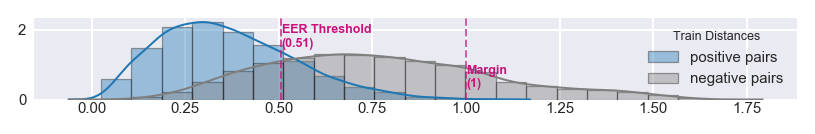


VALID: roc_auc: 0.8356, eer: 0.2539, thres: 0.5421 => acc: 0.7461, f1: 0.7460
val_loss: 0.170, loss: 0.152


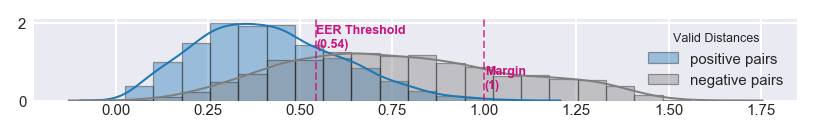

================================[   Epoch 66   ]================================
val_loss: 0.173, loss: 0.153
================================[   Epoch 67   ]================================
val_loss: 0.174, loss: 0.152
================================[   Epoch 68   ]================================
val_loss: 0.167, loss: 0.152
================================[   Epoch 69   ]================================
val_loss: 0.177, loss: 0.151
================================[   Epoch 70   ]================================
TRAIN: roc_auc: 0.8840, eer: 0.2042, thres: 0.5142 => acc: 0.7958, f1: 0.7958
val_loss: 0.171, loss: 0.152


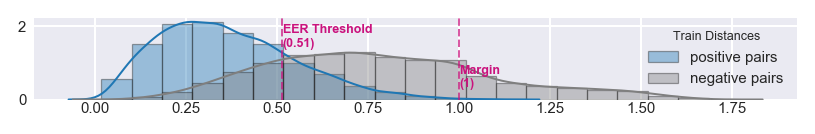


VALID: roc_auc: 0.8406, eer: 0.2421, thres: 0.5714 => acc: 0.7578, f1: 0.7577
val_loss: 0.171, loss: 0.152


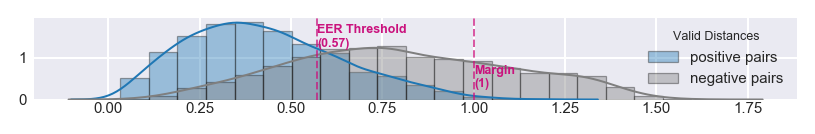

================================[   Epoch 71   ]================================
val_loss: 0.180, loss: 0.151
================================[   Epoch 72   ]================================
val_loss: 0.169, loss: 0.152
================================[   Epoch 73   ]================================
val_loss: 0.170, loss: 0.150
================================[   Epoch 74   ]================================
val_loss: 0.167, loss: 0.151
================================[   Epoch 75   ]================================
TRAIN: roc_auc: 0.8836, eer: 0.2050, thres: 0.5046 => acc: 0.7950, f1: 0.7950
val_loss: 0.167, loss: 0.150


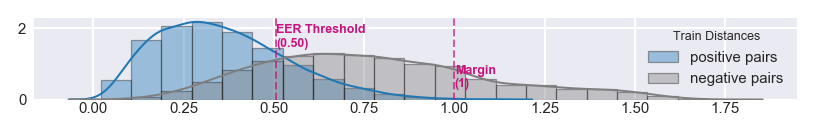


VALID: roc_auc: 0.8418, eer: 0.2458, thres: 0.5460 => acc: 0.7539, f1: 0.7539
val_loss: 0.167, loss: 0.150


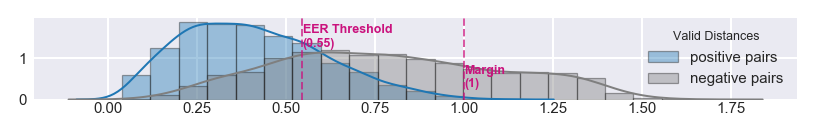

================================[   Epoch 76   ]================================
val_loss: 0.168, loss: 0.150
================================[   Epoch 77   ]================================
val_loss: 0.167, loss: 0.151
================================[   Epoch 78   ]================================
val_loss: 0.178, loss: 0.149
================================[   Epoch 79   ]================================
val_loss: 0.169, loss: 0.149
================================[ Final State ]================================
TRAIN: roc_auc: 0.8894, eer: 0.1993, thres: 0.5066 => acc: 0.8007, f1: 0.8007



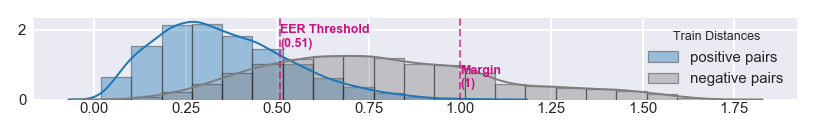


VALID: roc_auc: 0.8409, eer: 0.2414, thres: 0.5510 => acc: 0.7590, f1: 0.7590



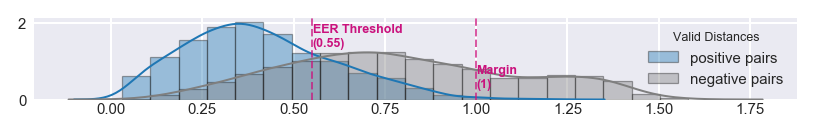

Training History:


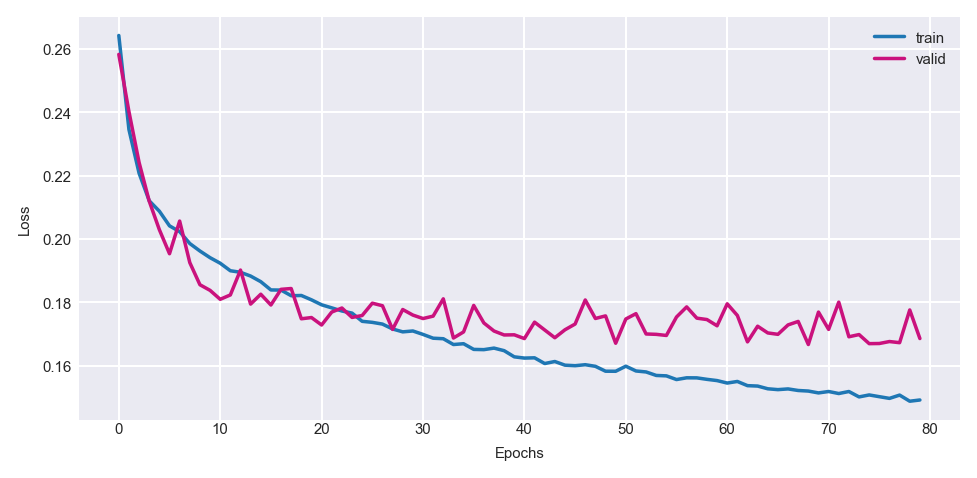

In [41]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
warnings.filterwarnings("ignore")
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
    epochs=P.epochs_max,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, save_plots=True)],
)

print("Training History:")
plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-epoch-trainloss.pdf"
)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

Mean distance: 0.60229
Max distance: 1.58071
Min distance: 0.03007


Histogram of Pair Distances:


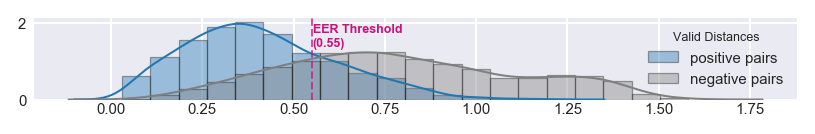

In [42]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

Using Model variant fcn...


C:\Users\ubo8fe\.conda\envs\continauth\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


================================[ Initial State ]================================
TRAIN: roc_auc: 0.4940, eer: 0.5113, thres: 0.0721 => acc: 0.4887, f1: 0.4887



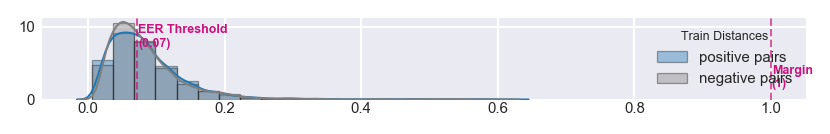

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.6654, eer: 0.3897, thres: 0.4828 => acc: 0.6104, f1: 0.6104
loss: 0.250


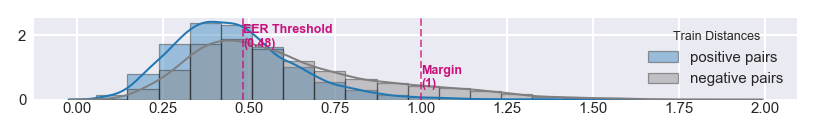

================================[   Epoch 1   ]================================
loss: 0.218
================================[   Epoch 2   ]================================
loss: 0.203
================================[   Epoch 3   ]================================
loss: 0.198
================================[   Epoch 4   ]================================
loss: 0.193
================================[   Epoch 5   ]================================
loss: 0.189
================================[   Epoch 6   ]================================
loss: 0.187
================================[   Epoch 7   ]================================
loss: 0.184
================================[   Epoch 8   ]================================
loss: 0.182
================================[   Epoch 9   ]================================
loss: 0.180
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.7893, eer: 0.2907, thres: 0.4804 => acc: 0.7093, f1: 0.7093
loss: 0.178


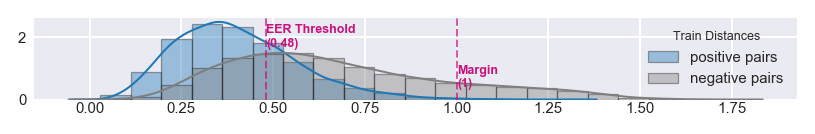

================================[   Epoch 11   ]================================
loss: 0.176
================================[   Epoch 12   ]================================
loss: 0.174
================================[   Epoch 13   ]================================
loss: 0.174
================================[   Epoch 14   ]================================
loss: 0.171
================================[   Epoch 15   ]================================
loss: 0.169
================================[   Epoch 16   ]================================
loss: 0.169
================================[   Epoch 17   ]================================
loss: 0.167
================================[   Epoch 18   ]================================
loss: 0.166
================================[   Epoch 19   ]================================
loss: 0.166
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.8347, eer: 0.2521, thres: 0.4817 => acc: 0.7479, f1: 0.7479
loss

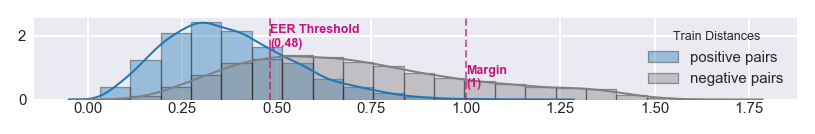

================================[   Epoch 21   ]================================
loss: 0.163
================================[   Epoch 22   ]================================
loss: 0.163
================================[   Epoch 23   ]================================
loss: 0.163
================================[   Epoch 24   ]================================
loss: 0.162
================================[   Epoch 25   ]================================
loss: 0.161
================================[   Epoch 26   ]================================
loss: 0.160
================================[   Epoch 27   ]================================
loss: 0.159
================================[   Epoch 28   ]================================
loss: 0.159
================================[   Epoch 29   ]================================
loss: 0.158
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.8476, eer: 0.2403, thres: 0.4909 => acc: 0.7597, f1: 0.7597
loss

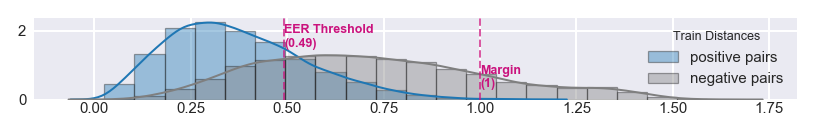

================================[   Epoch 31   ]================================
loss: 0.158
================================[   Epoch 32   ]================================
loss: 0.157
================================[   Epoch 33   ]================================
loss: 0.156
================================[   Epoch 34   ]================================
loss: 0.156
================================[   Epoch 35   ]================================
loss: 0.156
================================[   Epoch 36   ]================================
loss: 0.155
================================[   Epoch 37   ]================================
loss: 0.156
================================[   Epoch 38   ]================================
loss: 0.155
================================[   Epoch 39   ]================================
loss: 0.155
================================[ Final State ]================================
TRAIN: roc_auc: 0.8597, eer: 0.2279, thres: 0.5019 => acc: 0.7721, f1: 0.7721



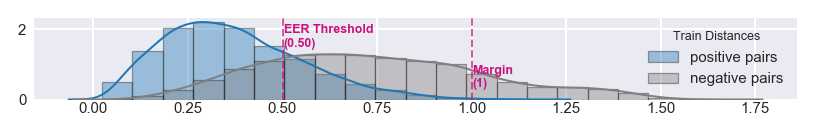

In [46]:
# Concat train & valid data
X_train_valid = [[], []]
X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
y_train_valid = np.hstack([y_train, y_valid])

# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)
    
# Compile
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=P.batch_size,
    epochs=P.epochs_best,
    verbose=0,
    callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=10, save_plots=False)],
)

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

In [47]:
model.save(str((OUTPUT_PATH / f"{P.name}_model.h5").resolve()))

In [48]:
# Clean Memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [49]:
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [50]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [51]:
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

C:\Users\ubo8fe\.conda\envs\continauth\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\ubo8fe\.conda\envs\continauth\lib\site-packages\keras\engine\saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     (None, 125, 3)            0         
_________________________________________________________________
basemodel (Model)            (None, 32)                18848     
Total params: 18,848
Trainable params: 18,592
Non-trainable params: 256
_________________________________________________________________


### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [52]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [53]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

In [54]:
# Concat Valid & Train (both were used for last Training)
df_train_temp = pd.concat([df_siamese_valid, df_siamese_train])
df_test_temp = df_ocsvm_train_valid

# Select data from 20 subjects of the TRAINING SET
random.seed(SEED)
ten_subjects = random.sample(df_train_temp["subject"].unique().tolist(), 20)
df_train_temp = df_train_temp[df_train_temp["subject"].isin(ten_subjects)].copy()
df_train_temp = df_train_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
random.seed(SEED)
ten_subjects = random.sample(df_test_temp["subject"].unique().tolist(), 10)
df_test_temp = df_test_temp[df_ocsvm_train_valid["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_train_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

First subject: 201848
y shape: (300,)
X shape: (300, 125, 3)


#### Predict Deep Features

In [55]:
deep_features_train = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_train.head(3))
display(deep_features_test.head(3))

0         1         2         3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31 subject
0  0.532730  0.601433  0.571256  0.679295  0.328800  0.522838  0.307816  0.113038  0.411330  0.680915  0.751487  0.556759  0.261712  0.334964  0.332459  0.290930  0.352191  0.082617  0.275497  0.432546  0.222125  0.863333  0.739540  0.627252  0.555983  0.738515  0.423250  0.250940  0.626917  0.616697  0.320039  0.615166  201848
1  0.534855  0.609086  0.554191  0.655128  0.338823  0.502882  0.306396  0.105658  0.410040  0.664141  0.758147  0.891228  0.239795  0.302278  0.340390  0.298235  0.359520  0.080062  0.290763  0.497089  0.234256  0.866880  0.726277  0.633459  0.550141  0.733180  0.440552  0.260601  0.612683  0.619079  0.309505  0.190129  201848
2  0.534626  0.603354  0.541992  0.621395  0.346483  0.490232  0.314961  0.122119  0.414695  0.655088  0.760665  0.891732  0.254550  0.276144  0.350316  0.305842  0.370322  0.082496  0.291532  0.484182  0.246326  0.859704  0.716168  0.624512  0.553221  0.728431  0.449565  0.270474  0.601504  0.625906  0.307474  0.216141  201848

0         1         2         3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31 subject
0  0.630102  0.389935  0.600983  0.995539  0.324329  0.344570  0.284509  0.476761  0.366598  0.741183  0.905276  0.809473  0.244208  0.984357  0.384095  0.417036  0.235889  0.071618  0.141243  0.102253  0.254466  0.726297  0.906846  0.663940  0.632994  0.678806  0.223640  0.058446  0.468353  0.618618  0.058556  0.985389  207696
1  0.610046  0.408789  0.624025  0.999667  0.327028  0.285955  0.261226  0.279809  0.314211  0.759063  0.926064  0.710405  0.144351  0.999541  0.388117  0.440350  0.213600  0.030905  0.143739  0.304149  0.235000  0.844738  0.944485  0.705429  0.619446  0.750119  0.161001  0.025577  0.473242  0.578520  0.035083  0.998814  207696
2  0.617656  0.424365  0.588124  0.988008  0.330435  0.366511  0.289660  0.425268  0.378557  0.725200  0.888119  0.811422  0.253652  0.955892  0.382949  0.398077  0.257212  0.081282  0.161917  0.129048  0.255334  0.738995  0.881111  0.658824  0.619480  0.676209  0.260377  0.083013  0.484008  0.621714  0.080926  0.960208  207696

### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

In [56]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(5.473 / 1.5, 5.473 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

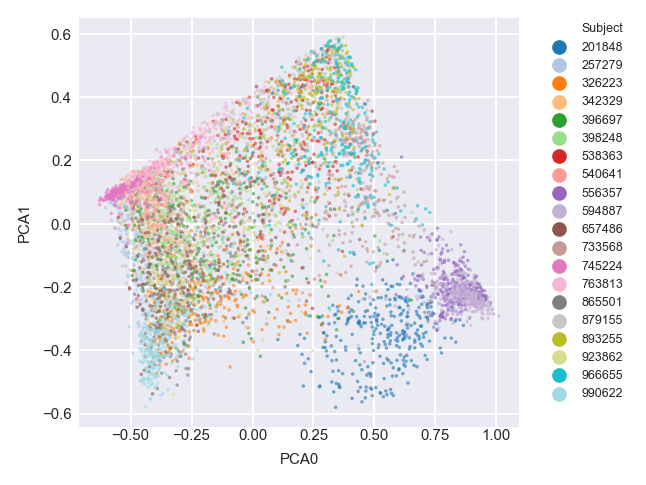

In [57]:
plot_pca(deep_features_train)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-train.pdf")

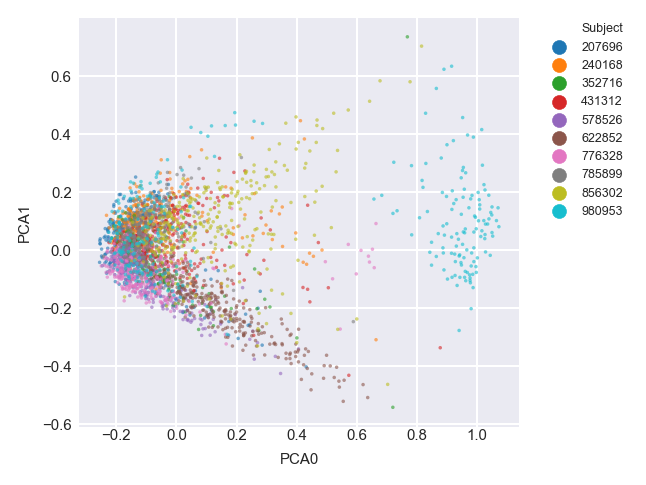

In [58]:
plot_pca(deep_features_test)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-test.pdf")

In [59]:
### Cleanup memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_
%reset_selective -f pca

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

In [60]:
df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.head()

X subject            session  task_type
0  ((1.3978850635805664, 6.634745158553127, 8.873...  207696  207696_session_11          2
1  ((0.8989105212499999, 7.4393458625, 5.20084218...  207696  207696_session_11          2
2  ((-0.8528512094444445, 5.462304877777777, 7.74...  207696  207696_session_11          2
3  ((-2.062305483175016, 4.1703999289186555, 7.23...  207696  207696_session_11          2
4  ((-0.9964742910047201, 4.9818725305168, 8.2125...  207696  207696_session_11          2

### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

In [61]:
def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model

**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

In [62]:
df_ocsvm_train_valid.head()

X subject            session  task_type
0  ((1.3978850635805664, 6.634745158553127, 8.873...  207696  207696_session_11          2
1  ((0.8989105212499999, 7.4393458625, 5.20084218...  207696  207696_session_11          2
2  ((-0.8528512094444445, 5.462304877777777, 7.74...  207696  207696_session_11          2
3  ((-2.062305483175016, 4.1703999289186555, 7.23...  207696  207696_session_11          2
4  ((-0.9964742910047201, 4.9818725305168, 8.2125...  207696  207696_session_11          2

In [63]:
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores

for run in tqdm(range(3)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

In [64]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv")
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_nu",
            "param_gamma",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

Best results for each owner:


owner  param_nu  param_gamma  rank_test_eer  mean_test_eer  std_test_eer  mean_test_accuracy  std_test_accuracy
446   622852  0.177592     6.250552            1.0       0.144939      0.088237            0.875661           0.074686
1406  622852  0.177592     6.250552            1.0       0.207389      0.082763            0.812169           0.078923
2126  207696  0.177592     6.250552            1.0       0.234057      0.135951            0.797619           0.122567
1806  785899  0.177592     6.250552            1.0       0.234362      0.096577            0.801587           0.088020
2206  622852  0.177592     6.250552            1.0       0.234714      0.053715            0.806878           0.068452
1246  785899  0.177592     6.250552            1.0       0.238865      0.076039            0.792328           0.069441
1466  578526  0.165351    25.595479            1.0       0.245940      0.046283            0.773810           0.049880
645   785899  0.104147     8.286428            1.0       0.248065      0.086426            0.785714           0.084366
1056  207696  0.055184    19.306977            1.0       0.251459      0.094805            0.779101           0.097220
14    352716  0.153110    25.595479            1.0       0.265119      0.029941            0.764550           0.052578




Most relevant statistics:


mean_fit_time   param_nu  param_gamma  mean_test_accuracy  std_test_accuracy  mean_test_eer  std_test_eer
count      36.000000  36.000000    36.000000           36.000000          36.000000      36.000000     36.000000
mean        0.000386   0.155830    12.963256            0.708848           0.076972       0.318534      0.068432
std         0.000732   0.083835     9.565549            0.071990           0.021661       0.069539      0.027915
min         0.000000   0.030702     0.001326            0.552910           0.041239       0.144939      0.027174
25%         0.000000   0.073545     6.250552            0.660714           0.060098       0.261704      0.050551
50%         0.000000   0.165351     8.286428            0.703704           0.078745       0.348469      0.071402
75%         0.000000   0.177592    25.595479            0.766865           0.085280       0.362760      0.088247
max         0.001739   0.300000    25.595479            0.875661           0.122567       0.461055      0.135951

**Plot parameters of top n of 30 results for every Owner:**

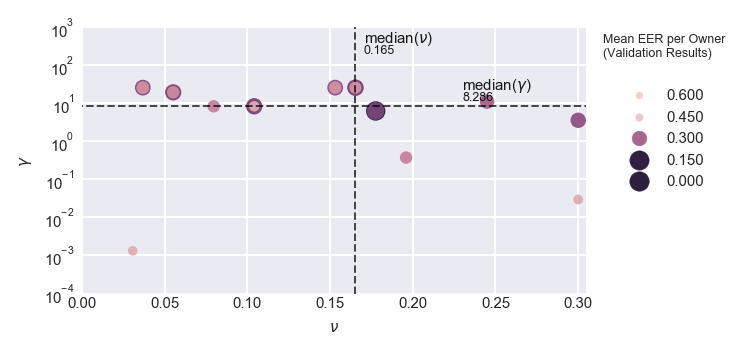

In [65]:
utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [69]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [70]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)
df_results.head()

fit_time  score_time  test_eer     train_eer  test_accuracy  train_accuracy   owner
0  0.015592         0.0  0.379310  1.818989e-12       0.666667        0.825397  808022
1  0.000000         0.0  0.200000  1.818989e-12       0.821429        0.825397  808022
2  0.000000         0.0  0.127660  1.818989e-12       0.916667        0.825397  808022
3  0.000000         0.0  0.526316  1.818989e-12       0.452381        0.825397  808022
4  0.000000         0.0  0.409836  1.818989e-12       0.630952        0.825397  808022

**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [71]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

Overall mean: 0.6530


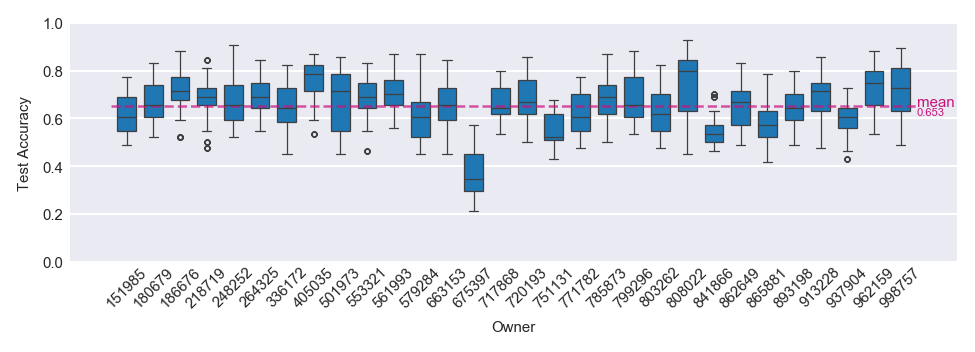

In [72]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

Overall mean: 0.3684


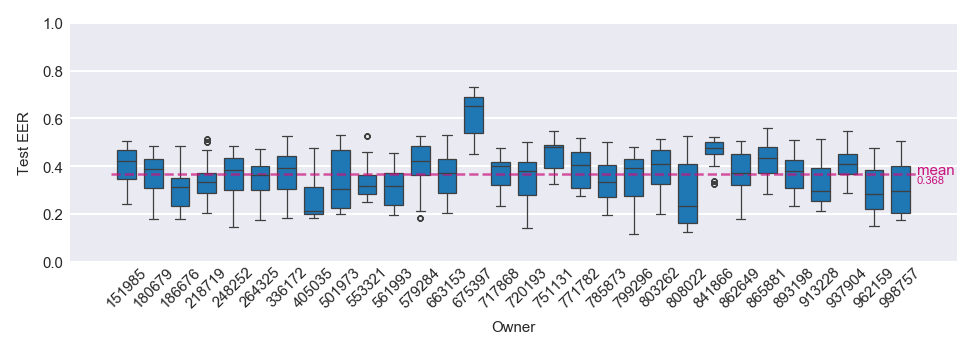

In [73]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [74]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

fit_time  score_time  test_eer     train_eer   owner  train_samples
0       0.0         0.0       0.5  1.818989e-12  808022              1
1       0.0         0.0       0.5  1.818989e-12  808022              1
2       0.0         0.0       0.5  1.818989e-12  808022              1
3       0.0         0.0       0.5  1.818989e-12  808022              1
4       0.0         0.0       0.5  1.818989e-12  808022              1

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [75]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

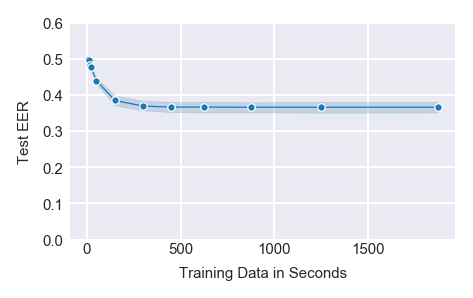

In [76]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [77]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

fit_time  score_time  test_eer     train_eer   owner  run
0       0.0         0.0       0.5  1.818989e-12  808022    0
1       0.0         0.0       0.5  1.818989e-12  808022    0
2       0.0         0.0       0.0  1.818989e-12  808022    0
3       0.0         0.0       0.0  1.818989e-12  808022    0
4       0.0         0.0       0.5  1.818989e-12  808022    0

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [78]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

Mean samples: 24.1
Mean seconds: 120.5


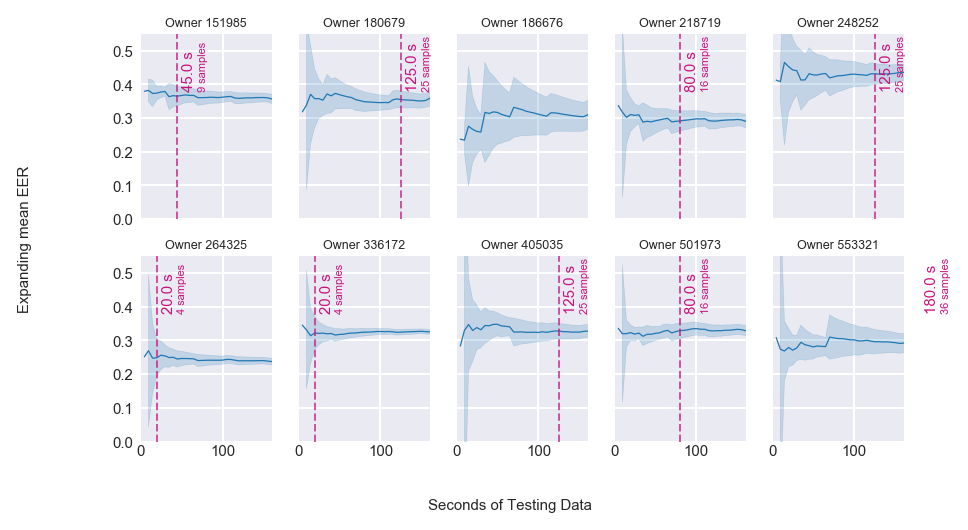

In [79]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)